# **Analisis Pola Pembelian Pelanggan dengan Algoritma Apriori**

- **Nama**: Sarwahita Dwi Prasanti
- **NIM**: A11.2022.13987
- **Mata Kuliah**: Sistem Temu Kembali Informasi (STKI) A11.4701

### **Ringkasan**
Proyek ini bertujuan untuk menganalisis sentimen ulasan pelanggan Amazon menggunakan algoritma **Naive Bayes** untuk klasifikasi sentimen dan **Latent Dirichlet Allocation (LDA)** untuk analisis topik. Data diolah dari teks mentah menjadi format numerik dengan **TF-IDF Vectorizer**, kemudian dianalisis untuk mengidentifikasi sentimen (positif/negatif) dan tema utama dalam ulasan.

### **Permasalahan**
Bagaimana membangun model otomatis untuk:
1. Menganalisis sentimen ulasan pelanggan (positif/negatif).
2. Mengidentifikasi tema utama dalam ulasan menggunakan pendekatan pemodelan topik.

### **Tujuan**
1. Mengembangkan model berbasis Naive Bayes untuk klasifikasi sentimen.
2. Melakukan analisis tema dengan LDA untuk menemukan pola dalam ulasan.
3. Memberikan hasil analisis yang dapat digunakan untuk meningkatkan strategi bisnis.

In [1]:
import pandas as pd
import numpy as np
import nltk
import re
from nltk.corpus import stopwords
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.naive_bayes import MultinomialNB
from sklearn.metrics import classification_report, confusion_matrix, accuracy_score
from sklearn.decomposition import LatentDirichletAllocation
import seaborn as sns
import matplotlib.pyplot as plt
import joblib

## **Dataset**
Dataset berasal dari Kaggle: [Amazon Reviews Dataset](https://www.kaggle.com/datasets/kritanjalijain/amazon-reviews). Dataset terdiri dari:
- **Train Dataset**: Melatih model klasifikasi.
- **Test Dataset**: Mengevaluasi performa model.
- **Sampled Train Dataset**: Untuk pelatihan awal sebelum diperbarui dengan dataset utama.

Kolom dataset:
- **Polarity**: Label sentimen (1 untuk negatif, 2 untuk positif).
- **Title**: Judul ulasan.
- **Text**: Isi ulasan.

In [2]:
# Step 1: Load Data
train_df = pd.read_csv("train.csv", header=None)
test_df = pd.read_csv("test.csv", header=None)
sample_df = pd.read_csv("sampled_train.csv", header=None)

In [3]:
# Add headers
train_df.columns = ['polarity', 'title', 'text']
test_df.columns = ['polarity', 'title', 'text']
sample_df.columns = ['polarity', 'title', 'text']

In [4]:
# Step 2: Combine columns for analysis
train_df['reviewText'] = train_df['title'] + " " + train_df['text']
test_df['reviewText'] = test_df['title'] + " " + test_df['text']
sample_df['reviewText'] = sample_df['title'] + " " + sample_df['text']

 **Pembersihan Data**:
   - Menghapus nilai duplikat pada kolom `reviewText`.
   - Mengonversi `polarity` ke label biner (1 menjadi 0 untuk negatif, 2 menjadi 1 untuk positif).
   - Menghapus baris dengan nilai kosong pada `reviewText`.

In [5]:
# Step 3: Data Cleaning
train_df = train_df.drop_duplicates(subset=['reviewText'])
test_df = test_df.drop_duplicates(subset=['reviewText'])
sample_df = sample_df.drop_duplicates(subset=['reviewText'])

train_df = train_df[['polarity', 'reviewText']]
test_df = test_df[['polarity', 'reviewText']]
sample_df = sample_df[['polarity', 'reviewText']]

In [6]:
# Map polarity labels
label_map = {1: 0, 2: 1}
train_df['polarity'] = train_df['polarity'].map(label_map)
test_df['polarity'] = test_df['polarity'].map(label_map)
sample_df['polarity'] = sample_df['polarity'].map(label_map)

train_df = train_df.dropna(subset=['reviewText'])
test_df = test_df.dropna(subset=['reviewText'])
sample_df = sample_df.dropna(subset=['reviewText'])

In [7]:
# Step 4: Text Preprocessing
nltk.download('stopwords')
stop_words = set(stopwords.words('english'))

def preprocess_text(text):
    text = re.sub(r"[^a-zA-Z\s]", "", text)  # Remove numbers and punctuation
    text = text.lower()  # Lowercase
    text = text.split()  # Tokenization
    text = [word for word in text if word not in stop_words]  # Remove stopwords
    return " ".join(text)

train_df['reviewText'] = train_df['reviewText'].apply(preprocess_text)
test_df['reviewText'] = test_df['reviewText'].apply(preprocess_text)
sample_df['reviewText'] = sample_df['reviewText'].apply(preprocess_text)

[nltk_data] Error loading stopwords: <urlopen error [WinError 10060] A
[nltk_data]     connection attempt failed because the connected party
[nltk_data]     did not properly respond after a period of time, or
[nltk_data]     established connection failed because connected host
[nltk_data]     has failed to respond>


Inisialisasi TF-IDF Vectorizer: menetapkan jumlah fitur maksimum (contoh: 1000 kata paling sering digunakan) dan menghapus kata-kata umum (stop words).
Transformasi Teks: Data teks ulasan dikonversi ke bentuk matriks numerik.
Label Target: Kolom polarity digunakan sebagai label untuk klasifikasi sentimen.

In [8]:
# Step 5: TF-IDF Vectorization
tfidf = TfidfVectorizer(max_features=1000, stop_words='english')
X_sample_train = tfidf.fit_transform(sample_df['reviewText'])
X_train = tfidf.transform(train_df['reviewText'])
X_test = tfidf.transform(test_df['reviewText'])

# Extract target labels
y_sample_train = sample_df['polarity'].values
y_train = train_df['polarity'].values
y_test = test_df['polarity'].values

Model MultinomialNB diinisialisasi dan dilatih menggunakan data pelatihan (X_train, y_train).
Fungsi partial_fit digunakan untuk memperbarui model dengan data baru, di mana classes=np.unique(y_train) menentukan kelas target yang digunakan dalam pelatihan.

In [9]:
# Step 6: Train and Update Model
model = MultinomialNB()
model.fit(X_sample_train, y_sample_train)
model.partial_fit(X_train, y_train, classes=np.unique(y_train))

MultinomialNB()

Setelah model dilatih, dilakukan prediksi pada data uji (X_test) menggunakan metode predict().
Kemudian, dilakukan evaluasi dengan menghitung:
Akurasi: mengukur seberapa tepat prediksi model dibandingkan dengan label yang sebenarnya.
Confusion Matrix: Matriks yang menunjukkan jumlah prediksi yang benar dan salah, membandingkan label yang diprediksi dengan label asli. Di sini, hasil confusion matrix menunjukkan dua kelas dengan jumlah total prediksi benar (benar kelas 0 dan 1) serta kesalahan prediksi.
Classification Report: Laporan yang lebih mendalam tentang metrik kinerja model, yang mencakup presisi, recall, dan F1-score untuk masing-masing kelas. Hasilnya menunjukkan performa model yang cukup baik dengan nilai-nilai yang seimbang antara kedua kelas.

In [10]:
# Step 7: Evaluate Model
y_pred = model.predict(X_test)
print("Accuracy:", accuracy_score(y_test, y_pred))
print("Confusion Matrix:\n", confusion_matrix(y_test, y_pred))
print("Classification Report:\n", classification_report(y_test, y_pred))

Accuracy: 0.8266946016761005
Confusion Matrix:
 [[163081  36903]
 [ 32415 167577]]
Classification Report:
               precision    recall  f1-score   support

           0       0.83      0.82      0.82    199984
           1       0.82      0.84      0.83    199992

    accuracy                           0.83    399976
   macro avg       0.83      0.83      0.83    399976
weighted avg       0.83      0.83      0.83    399976



Confusion Matrix, yang menggambarkan hasil prediksi model terhadap data uji dengan dua kelas, yaitu 0 dan 1. Matriks ini menunjukkan jumlah prediksi yang benar dan salah, dengan nilai True Negative (0, 0) sebesar 163,081, False Positive (0, 1) sebesar 36,903, False Negative (1, 0) sebesar 32,415, dan True Positive (1, 1) sebesar 167,577.

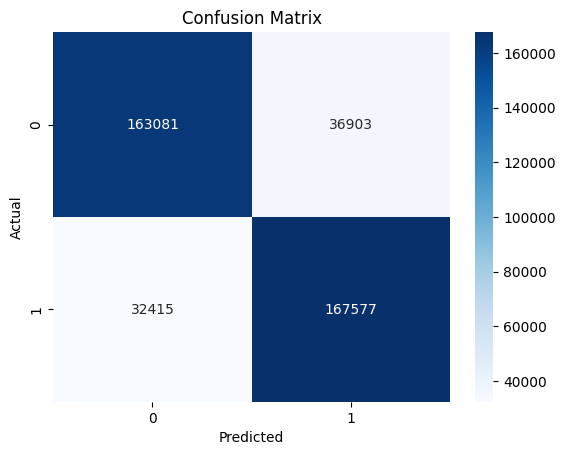

In [11]:
# Step 8: Visualize Confusion Matrix
sns.heatmap(confusion_matrix(y_test, y_pred), annot=True, fmt="d", cmap="Blues")
plt.xlabel("Predicted")
plt.ylabel("Actual")
plt.title("Confusion Matrix")
plt.show()

Topic Modeling dengan LDA (Latent Dirichlet Allocation), digunakan untuk menemukan topik-topik utama dalam dataset teks. LDA membantu mengidentifikasi kata-kata yang sering muncul dalam setiap topik, seperti Topik 1 yang berfokus pada buku dan pembacaan, Topik 2 terkait dengan film dan karakter, dan Topik 3 yang berkaitan dengan musik dan lagu.

In [12]:
# Step 9: Topic Modeling with LDA
lda = LatentDirichletAllocation(n_components=5, random_state=42)
lda.fit(X_train)

# Display topics
def display_topics(model, feature_names, no_top_words):
    topics = []
    for topic_idx, topic in enumerate(model.components_):
        topic_words = " | ".join([feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]])
        print(f"Topik {topic_idx + 1}: {topic_words}")
        topics.append(f"Topik {topic_idx + 1}: {topic_words}")
    return topics

topics = display_topics(lda, tfidf.get_feature_names_out(), 10)

Topik 1: book | read | books | good | great | author | information | reading | written | life
Topik 2: movie | book | game | story | like | good | read | film | great | characters
Topik 3: cd | album | music | songs | like | song | great | best | good | sound
Topik 4: product | use | great | work | good | works | dont | bought | buy | money
Topik 5: product | great | amazon | item | price | received | ordered | bought | gift | good


Visualisasi dalam bentuk grafik batang menggambarkan seberapa penting atau sering topik-topik tersebut dibahas dalam dataset, membantu memahami distribusi topik secara grafis.

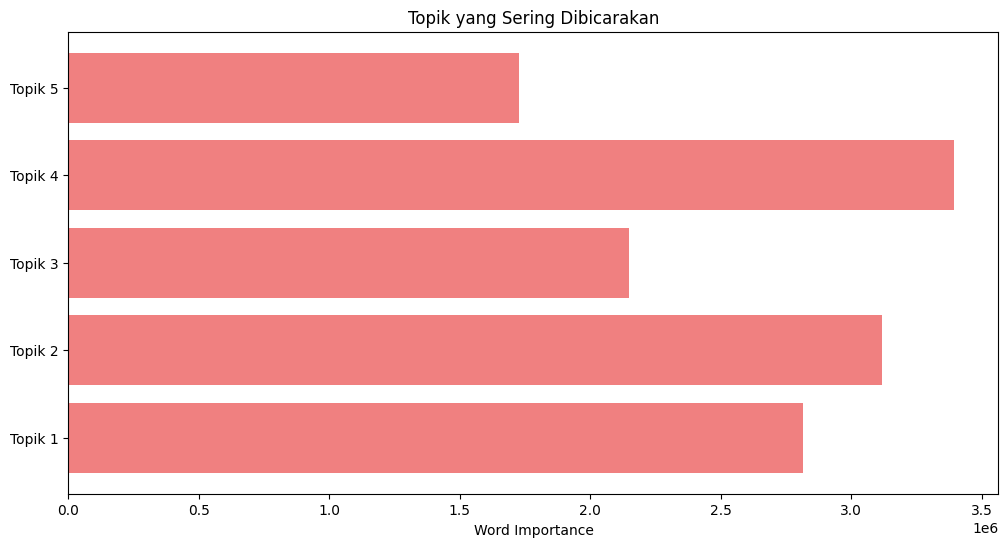

In [13]:
# Visualize topics
def visualize_topics(model, feature_names, no_top_words):
    topic_words = []
    for topic in model.components_:
        words = [feature_names[i] for i in topic.argsort()[:-no_top_words - 1:-1]]
        topic_words.append(" | ".join(words))

    plt.figure(figsize=(12, 6))
    plt.barh(range(len(topic_words)), model.components_.sum(axis=1), color='lightcoral')
    plt.yticks(range(len(topic_words)), [f"Topik {i+1}" for i in range(len(topic_words))])
    plt.xlabel("Word Importance")
    plt.title("Topik yang Sering Dibicarakan")
    plt.show()

visualize_topics(lda, tfidf.get_feature_names_out(), 10)

menyimpan model dan vectorizer yang telah dilatih ke dalam file untuk digunakan untuk deploying.

In [14]:
# Step 10: Save Model and Vectorizer
joblib.dump(tfidf, 'vectorizer.pkl')
joblib.dump(model, 'model.pkl')

print("Model and vectorizer have been saved.")

Model and vectorizer have been saved.
